# Utilizar a rede Siamesa para classificação
* Escolher 1 a 5 imagens para comparação
* Estabelecer uma métrica para decidir qual classe correta

In [1]:
import numpy as np
import os
import random
import tensorflow as tf
import time

from collections import Counter
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


caminho_bases = os.path.join('..', 'bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

SIZE = (224, 224)

# Carrega imagens

In [120]:
BATCH_SIZE = 256
datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
validation_generator = datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20845 images belonging to 2 classes.
Found 2317 images belonging to 2 classes.


# Models

In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D


SIZE = (224, 224)


nuclear_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Flatten(),
  Dense(128, activation='relu'),
 
])

a_in = Input(shape=(*SIZE, 3))
b_in = Input(shape=(*SIZE, 3))

a_feat = nuclear_model(a_in)
b_feat = nuclear_model(b_in)

combined_features = concatenate([a_feat, b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.Model(inputs = [a_in, b_in], outputs = [combined_features], name = 'Similarity_Model')

In [122]:
MODEL_DIR = '../models/siamese'
epoch = 1
val_loss = 0.11

epoch = 6
val_loss = 0.24

similarity_model.load_weights(os.path.join(
    MODEL_DIR, 
    '04modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
    )
)


# Imagens escolhidas para comparação

(224, 224)


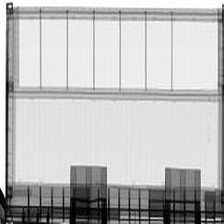

In [123]:
vazio1 = Image.open(os.path.join(caminho_train, 'vazio/5aa1a06e2a87954aafdda3bc.jpg'))
vazio1 = vazio1.resize(SIZE, Image.ANTIALIAS)
print(vazio1.size)
vazio1

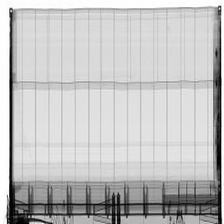

In [124]:
vazio2 = Image.open(os.path.join(caminho_train, 'vazio/5aa1cc192a87957e60f49482.jpg'))
vazio2 = vazio2.resize(SIZE, Image.ANTIALIAS)
vazio2

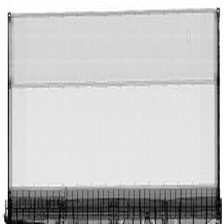

In [125]:
vazio3 = Image.open(os.path.join(caminho_train, 'vazio/5aabe7f62a879503d804ff94.jpg'))
vazio3 = vazio3.resize(SIZE, Image.ANTIALIAS)
vazio3


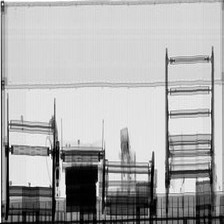

In [126]:
nvazio1 = Image.open(os.path.join(caminho_train, 'nvazio/5aa1a5222a87954aaedda574.jpg'))
nvazio1 = nvazio1.resize(SIZE, Image.ANTIALIAS)
nvazio1

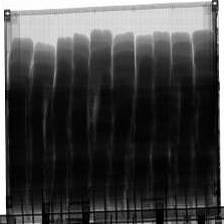

In [127]:
nvazio2 = Image.open(os.path.join(caminho_test, 'nvazio/5aa1a52f2a87954aaedda9cc.jpg'))
nvazio2 = nvazio2.resize(SIZE, Image.ANTIALIAS)
nvazio2

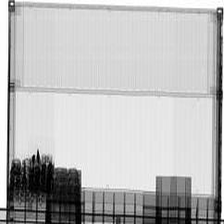

In [128]:
# 5aa1cc732a87957e63f4ba9f
# 5aa1a52f2a87954aaedda9cc
nvazio3 = Image.open(os.path.join(caminho_train, 'nvazio/5aa1cc732a87957e63f4ba9f.jpg'))
nvazio3 = nvazio3.resize(SIZE, Image.ANTIALIAS)
nvazio3


# Montagem do batch

In [129]:
def monta_x1_batch(pil_image):
    x1 = np.zeros((BATCH_SIZE, *SIZE, 3), np.float32)
    img_array = np.array(pil_image) / 255
    for ind in range(BATCH_SIZE):
        x1[ind, :, :, :] = img_array
    return x1

def get_preds(generator, X_batch):
    generator.reset()
    y = []
    y_pred = []
    for r in range(len(validation_generator)):
        x2_batch, y_batch = next(validation_generator)
        pred_batch = similarity_model.predict([X_batch[:len(x2_batch)], x2_batch])
        y.extend(y_batch)
        y_pred.extend(list(pred_batch.reshape(-1)))
    return y, y_pred

def evaluate(pil_image, inverso=False):
    X_batch = monta_x1_batch(pil_image)
    y_test, y_pred = get_preds(validation_generator, X_batch)
    if inverso:
        y_labels = np.array(y_pred) > 0.5
    else:
        y_labels = np.array(y_pred) <= 0.5
    print(sum(y_labels == y_test) / len(y_labels))
    return y_test, y_pred 
    

In [131]:
%time y_test, y_predv1 = evaluate(vazio1)

0.9602934829520933
CPU times: user 7.16 s, sys: 1.25 s, total: 8.41 s
Wall time: 10.6 s


In [132]:
%time y_test, y_predv2 = evaluate(vazio2)

0.9598618903754855
CPU times: user 6.58 s, sys: 1.22 s, total: 7.8 s
Wall time: 10 s


In [133]:
%time y_test, y_predv3 = evaluate(vazio3)

0.9602934829520933
CPU times: user 6.65 s, sys: 1.21 s, total: 7.87 s
Wall time: 10 s


In [134]:
%time y_test, y_prednv1 = evaluate(nvazio1, inverso=True)

0.9602934829520933
CPU times: user 6.59 s, sys: 1.29 s, total: 7.88 s
Wall time: 10 s


In [135]:
%time y_test, y_prednv2 = evaluate(nvazio2, inverso=True)

0.9598618903754855
CPU times: user 6.68 s, sys: 1.22 s, total: 7.89 s
Wall time: 10.1 s


In [136]:
%time y_test, y_prednv3 = evaluate(nvazio3, inverso=True)

0.9598618903754855
CPU times: user 6.61 s, sys: 1.36 s, total: 7.97 s
Wall time: 10.2 s


In [137]:
x1_batch_vazio = monta_x1_batch(vazio1)
x1_batch_nvazio = monta_x1_batch(nvazio1)
x2_batch, y_batch = next(validation_generator)
y_pred_vazio = similarity_model.predict([x1_batch_vazio, x2_batch])
y_pred_nvazio = similarity_model.predict([x1_batch_nvazio, x2_batch])

In [138]:
y_pred_vazio

array([[0.80489945],
       [0.8015746 ],
       [0.1976147 ],
       [0.8142503 ],
       [0.68003225],
       [0.2462168 ],
       [0.79886496],
       [0.20021471],
       [0.20019001],
       [0.7991556 ],
       [0.8204527 ],
       [0.79792446],
       [0.55399215],
       [0.24903801],
       [0.20089978],
       [0.25803158],
       [0.19961867],
       [0.8272952 ],
       [0.20655525],
       [0.20322573],
       [0.20962304],
       [0.21034938],
       [0.20580706],
       [0.7968216 ],
       [0.40013245],
       [0.7963809 ],
       [0.80414283],
       [0.7980053 ],
       [0.77718556],
       [0.8076203 ],
       [0.82036406],
       [0.7838811 ],
       [0.20932215],
       [0.7896509 ],
       [0.79296577],
       [0.26119113],
       [0.76904595],
       [0.20881358],
       [0.30355406],
       [0.19538644],
       [0.22407195],
       [0.20409852],
       [0.3255629 ],
       [0.22031528],
       [0.8063518 ],
       [0.8176984 ],
       [0.25406694],
       [0.822

In [139]:
y_pred_nvazio

array([[0.00406069],
       [0.00301254],
       [0.92041343],
       [0.00303096],
       [0.1246179 ],
       [0.8481765 ],
       [0.00301361],
       [0.91610384],
       [0.93071306],
       [0.00311464],
       [0.00348794],
       [0.002985  ],
       [0.26579684],
       [0.8457984 ],
       [0.9365053 ],
       [0.8351841 ],
       [0.93161523],
       [0.00271043],
       [0.9143449 ],
       [0.9428421 ],
       [0.9349166 ],
       [0.9529068 ],
       [0.9169397 ],
       [0.00269538],
       [0.45823273],
       [0.00681397],
       [0.00282368],
       [0.00310406],
       [0.00364056],
       [0.00280455],
       [0.00402763],
       [0.0037879 ],
       [0.94345057],
       [0.01782292],
       [0.00729126],
       [0.8245983 ],
       [0.00434431],
       [0.946239  ],
       [0.7237544 ],
       [0.9327194 ],
       [0.91295   ],
       [0.9118482 ],
       [0.6550449 ],
       [0.93038225],
       [0.00293553],
       [0.00585151],
       [0.8917345 ],
       [0.007

In [140]:
y_labels = (y_pred_vazio < y_pred_nvazio)

In [141]:
sum(y_labels.reshape(-1) == y_batch) / len(y_labels)

0.6484375

In [142]:
y_pred_vazios = (np.array(y_predv1) +  np.array(y_predv2) + np.array(y_predv3)) / 3

In [143]:
y_pred_vazios

array([0.85757023, 0.8554978 , 0.1536935 , ..., 0.15066583, 0.19184677,
       0.26656628], dtype=float32)

In [144]:
y_labels = y_pred_vazios <= 0.5
sum(y_labels == y_test) / len(y_labels)

0.9602934829520933

In [145]:
y_pred_nvazios = (np.array(y_prednv1) +  np.array(y_prednv2) + np.array(y_prednv3)) / 3

In [146]:
y_labels = y_pred_nvazios > 0.5
sum(y_labels == y_test) / len(y_labels)

0.9598618903754855

In [148]:
y_labels = (y_pred_vazios < y_pred_nvazios).reshape(-1)
sum(y_labels == y_test) / len(y_labels)

0.9598618903754855

In [150]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_labels))
print(classification_report(y_test, y_labels, digits=4))

[[1076   90]
 [   3 1148]]
             precision    recall  f1-score   support

        0.0     0.9972    0.9228    0.9586      1166
        1.0     0.9273    0.9974    0.9611      1151

avg / total     0.9625    0.9599    0.9598      2317



## A diferença entre comparar a imagem com exemplos de vazios e não vazios e checar qual a similaridade maior parece ser o método mais preciso, alcançando desempenho similar ao dos melhores classificadores treinados anteriormente

## É possível ajustar a sensibilidade mudando os exemplos comparados (por exemplo pegando contêineres não vazios com mais carga???) Testar!!

In [151]:
len(y_batch)

256

In [152]:
len(y_test)

2317